# 2022-08-21 • Area under STA (new conntest)

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [6]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin; same as previous nb's.

In [20]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
);

## Run sim

In [21]:
s = cached(sim, [p.sim]);

In [22]:
s = augment_simdata(s, p);

## New connection test statistic

In [24]:
ii = s.input_info[1];

In [13]:
using PyPlot

[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


In [59]:
using VoltoMapSim.Plot

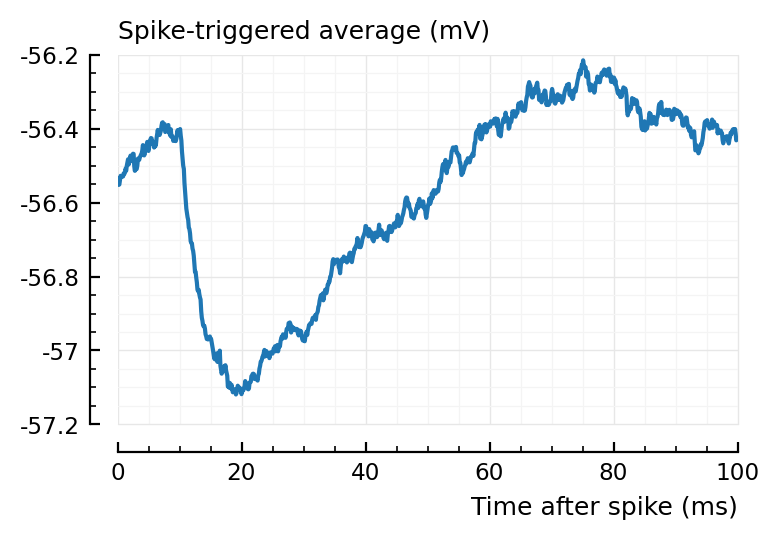

In [26]:
plotSTA(ii.v, ii.spiketrains.conn.inh[1], p);

In [28]:
sta = calc_STA(ii.v, ii.spiketrains.conn.inh[1], p);

In [34]:
t = sum(sta .- sta[1]);

What are the units? Sum of: voltage * dt.  
So units are volt·second. But I'd had to add the dt to every term.
I can do afterwards.

In [35]:
dt = p.sim.general.Δt;

In [38]:
t * dt / (mV * ms)

-3.55

(Estimate from graph for how big this should be: approx 0.5 mV difference, times 40 ms or so.
So 20 mV·ms. Sure).
How much is above and below?

In [41]:
sig = (sta .- sta[1]) * dt / (mV*ms)
above = sum(sig[sig .> 0])
below = sum(sig[sig .< 0])
above, below

(9, -12.5)

Nice, so yes units seem right.

How to name this measure.
It's area under STA, referenced to STA at t=0.
AUS? AUA?
relsum?  
Area over start.  
Just `area` is quite nice.

Adding this to `misc.jl`:

In [68]:
area(STA) = sum(STA .- STA[1]);

## Compare performance
..between test measures: existing (peak-to-peak) and the new.

In [49]:
p0 = p;
pn = (@set p.conntest.STA_test_statistic = "area");

In [62]:
cached_conntest_perf = VoltoMapSim.cached_conntest_perf;

In [72]:
perf0 = cached_conntest_perf(1, ii.v, ii.spiketrains, p0);

In [73]:
perf0.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

In [74]:
perfn = cached_conntest_perf(1, ii.v, ii.spiketrains, pn);

Testing connections: 100%|██████████████████████████████| Time: 0:00:24
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\51a268c55a44be7a.jld2` … done (4.5 s)


In [75]:
perfn.detection_rates

(TPR_exc = 0, TPR_inh = 0.8, FPR = 0.175)

Aha! It seems significantly worse than peak-to-peak (for this sim, this neuron).

Thing left to do is, use this to determine whether a presynaptic neuron is excitatory or inhibitory (now we're cheating and presupposing that knowledge in the conntest perf eval).

I think it's gonna make the performance way worse.

First, let's redo the test for the inhibitory recorded neuron.

In [79]:
ii_inh = s.input_info[801];

In [80]:
perf0 = cached_conntest_perf(801, ii_inh.v, ii_inh.spiketrains, p0);

Testing connections: 100%|██████████████████████████████| Time: 0:00:20
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\6a503ee8521e347c.jld2` … done


In [81]:
perf0.detection_rates

(TPR_exc = 0.714, TPR_inh = 0.9, FPR = 0.05)

In [82]:
perfn = cached_conntest_perf(801, ii_inh.v, ii_inh.spiketrains, pn);

Testing connections: 100%|██████████████████████████████| Time: 0:00:21
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\352d0f0ba159fa0b.jld2` … done


In [84]:
perfn.detection_rates

(TPR_exc = 0.381, TPR_inh = 0.7, FPR = 0.1)

Again, signifcantly worse performance.

## Use `area` just for deciding exc or inh

This was the original motivation for this measure.

Our current `test_connection` returns a p-value based on peak-to-peak. It only says _whether_ it thinks the presynaptic neuron is connected, not what type it is.
We'll add the `area` for that:

In [105]:
function test_connection_and_type(v, spikes, p)
    pval = test_connection(v, spikes, p)
    dt = p.sim.general.Δt
    A = area(calc_STA(v, spikes, p)) * dt / (mV*ms)
    if pval ≥ p.evaluation.α
        predicted_type = :unconn
    elseif A > 0
        predicted_type = :exc
    else
        predicted_type = :inh
    end
    return (; predicted_type, pval, area_over_start=A)
end;

In [106]:
test_connection_and_type(ii.v, ii.spiketrains.conn.inh[1], p)

(predicted_type = :inh, pval = 0.01, area_over_start = -3.55)

### Performance optimization sidebar

In [51]:
@time test_connection_and_type(ii.v, ii.spiketrains.conn.inh[1], p)

  0.853824 seconds (1.35 k allocations: 22.599 MiB)


(predicted_type = :inh, pval = 0.01, area = -3.55)

Sidenote, shuffle connection test takes a while. Profiling shows that almost all time is spent in the `calc_STA` addition loop.
```julia
STA .+= @view VI_sig[a:b]
```
Doesn't seem much more optimizable.

Wait, that broadcasting `.` is not necessary. Let's see what perf is without.

In [36]:
@time test_connection_and_type(ii.v, ii.spiketrains.conn.inh[1], p)

  5.284591 seconds (720.96 k allocations: 5.469 GiB, 20.00% gc time)


(predicted_type = :inh, pval = 0.01, area = -3.55)

Huh, perf is worse with it, and way more allocations. Weird. Revert.

Trying with manual for loop (and `@inbounds`):

[..]

this made a type instability problem apparent (manual loop super slow. → `@code_warntype`. much red. problem was that Δt not inferred (cause simtype abstract). manually adding type made manual loop fast; and the prev, non manual loop also faster :))

Yes good, the new profile now also shows that the majority of time is spent in `float:+`, as it should be.

Now testing whether sim itself suffers from this same type instability problem..

In [ ]:
# pshort = (@set p.sim.general.duration = 1*seconds);
# @code_warntype VoltoMapSim.init_sim(pshort.sim);
# state = VoltoMapSim.init_sim(pshort.sim);
#@code_warntype VoltoMapSim.step_sim!(state, pshort.sim, 1);

It doesn't. Type known-ness ("stability") seems good enough.

---

### Back on topic

Now use the new `test_connection_and_type` in a reworked `eval_conntest_perf` function:

In [39]:
using DataFrames

[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]


In [100]:
function evaluate_conntest_perf_v2(s, m, p)
    # s = augmented simdata
    # m = postsynaptic neuron ID
    ii = s.input_info[m]
    @unpack N_tested_presyn, rngseed = p.evaluation;
    resetrng!(rngseed)
    function get_sample(IDs)
        N = min(length(IDs), N_tested_presyn)
        return sample(IDs, N, replace = false, ordered = true)
    end
    df = DataFrame(
        input_neuron_ID = Int[],     # global ID
        real_type       = Symbol[],  # :unconn, :exc, :inh
        predicted_type  = Symbol[],  # idem
        pval            = Float64[],
        area_over_start = Float64[],
    )
    function test(IDs, real_type)
        for n in get_sample(IDs)
            o = test_connection_and_type(ii.v, s.spike_times[n], p)
            push!(df, Dict(pairs((; input_neuron_ID = n, real_type, o...))))
        end
    end
    test(ii.exc_inputs, :exc)
    test(ii.inh_inputs, :inh)
    test(ii.unconnected_neurons, :unconn)
    #return perf = (; df, detection_rates = (; TPR_exc, TPR_inh, FPR))
    return df
end;

In [109]:
df = evaluate_conntest_perf_v2(s, 1, p);

,input_neuron_ID,real_type,predicted_type,pval,area_over_start
,Int64,Symbol,Symbol,Float64,Float64
1,312,exc,unconn,0.54,11.3
2,565,exc,unconn,0.61,7.25
3,681,exc,unconn,0.55,6.58
4,597,exc,inh,0.02,-37.9
5,447,exc,unconn,0.68,1.42
6,766,exc,unconn,0.46,-7.55
7,132,exc,unconn,0.54,-20.9
8,139,exc,unconn,0.91,-22.8
9,446,exc,unconn,0.34,-27.5


In [107]:
ENV["LINES"] = 100

100